In [2]:
import os

In [3]:
%pwd

'/home/harsh_rana/Projects/Experiments/Deep Learning/Chicken-Disease-Classification-Using-MLOPS-DVC-Pipeline-/research'

In [4]:
os.chdir("../")

In [5]:
%pwd

'/home/harsh_rana/Projects/Experiments/Deep Learning/Chicken-Disease-Classification-Using-MLOPS-DVC-Pipeline-'

In [6]:
import tensorflow as tf

2025-01-08 14:40:21.164301: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 14:40:25.908738: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 14:40:25.917347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 14:40:34.182759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
model = tf.keras.models.load_model("artifacts/training/model.h5")

In [8]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    params_image_size: list
    params_batch_size: int

In [9]:
from cnnClassifier.constants import *
from cnnClassifier.utils.common import read_yaml, create_directories, save_json

In [10]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_validation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            training_data="artifacts/data_ingestion/Chicken-fecal-images",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return eval_config

In [11]:
from urllib.parse import urlparse

In [12]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    
    def _valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

    
    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = model.evaluate(self.valid_generator)

    
    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)


In [ ]:
try:
    config = ConfigurationManager()
    val_config = config.get_validation_config()
    evaluation = Evaluation(val_config)
    evaluation.evaluation()
    evaluation.save_score()

except Exception as e:
   raise e

[2025-01-08 14:41:00,790:INFO:common:yaml file: config/config.yaml loaded successfully]


[2025-01-08 14:41:00,923:INFO:common:yaml file: params.yaml loaded successfully]
[2025-01-08 14:41:00,942:INFO:common:created directory at: artifacts]
Found 238 images belonging to 2 classes.


2025-01-08 14:41:03.235067: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-01-08 14:41:04.756779: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2025-01-08 14:41:05.935861: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-01-08 14:41:06.007151: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2025-01-08 14:41:06.487571: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.


15/15 [==============================] - 115s 7s/step - loss: 0.5227 - accuracy: 0.9328
[2025-01-08 14:42:57,247:INFO:common:json file saved at: scores.json]


[2025-01-08 14:51:03,760:WARNING:font_manager:Matplotlib is building the font cache; this may take a moment.]
[2025-01-08 14:51:07,682:INFO:font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)]
[2025-01-08 14:51:21,556:INFO:font_manager:generated new fontManager]
Found 238 images belonging to 2 classes.
15/15 [==============================] - 112s 7s/step


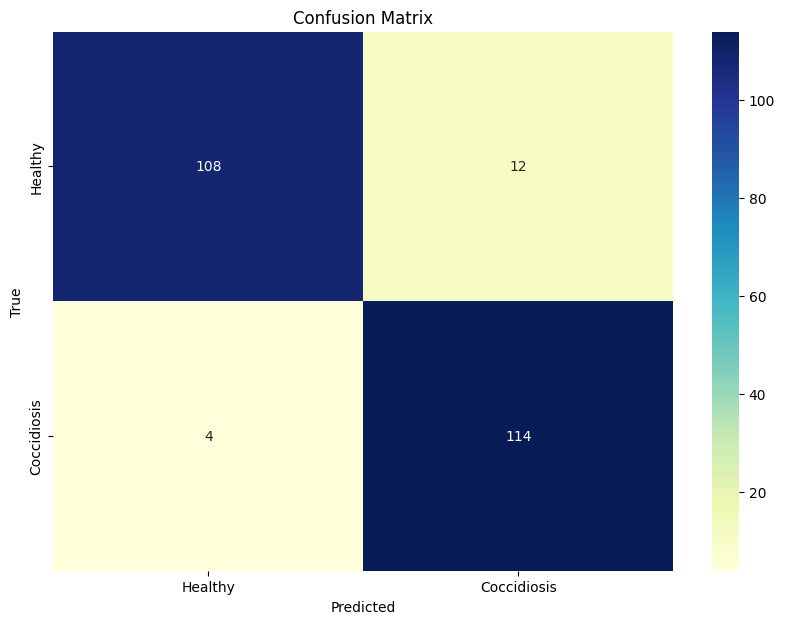

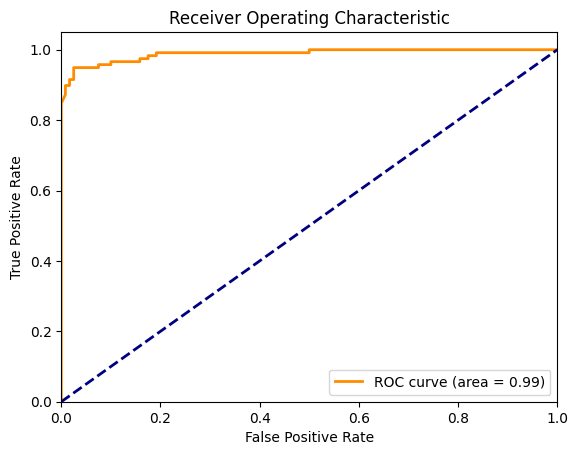

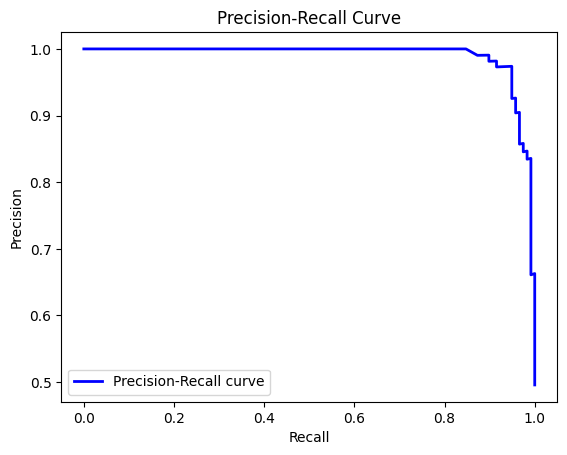

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import numpy as np


evaluation._valid_generator()  # Generate the validation data

# Generate true labels and predictions
y_true = evaluation.valid_generator.classes  # True labels
y_pred = evaluation.model.predict(evaluation.valid_generator)  # Predictions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices


def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()



def plot_precision_recall_curve(y_true, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, lw=2, color='b', label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Now you can use y_true and y_pred_classes for plotting
plot_confusion_matrix(y_true, y_pred_classes, classes=['Healthy', 'Coccidiosis'])
plot_roc_curve(y_true, y_pred[:, 1])  # Assuming binary classification and the second column is for the positive class
plot_precision_recall_curve(y_true, y_pred[:, 1])